In [16]:
import re
import json
import jsonlines as jl
from pathlib import Path
import itertools
from collections import defaultdict

import pickle

import warnings

import numpy as np

from keras.preprocessing.text import Tokenizer

import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
warnings.filterwarnings("ignore")

# Useful Constants

In [14]:
#################
# Paths and files
#################

# Data paths
INPUT_PATH = Path("..")/"input"
ALL_TRIPLES = Path(INPUT_PATH)/"triple_set.jsonl"

# Image paths
OUTPUT_PATH = Path("..")/"result"
WORD_DISTRIBUTION_CHART = Path(OUTPUT_PATH)/"word_distribution_keras_tokenizer.jpg"
TEXT_LENGTHS_BOX = Path(OUTPUT_PATH)/"corpus_text_lengths_in_tokens.png"
FIT_TOKENIZER = Path(OUTPUT_PATH)/"ft_tokenizer.pkl"

###########
# Сonstants
###########

# Data fields
ANCHOR = "anchor"
POSITIVE = "positive"
NEGATIVE = "negative"
TYPE2IDX = dict(anchor=0, positive=1, negative=2)

# Tokenizer parameters
MAX_VOCAB_SIZE = 20000
MAX_DOC_FREQUENCY = 0.8
MIN_TOKEN_COUNT = 10
OOV_TOKEN = 1

# Loading Data & Fitting Tokenizer

In [4]:
def load_triples(_file):
    with jl.open(_file, mode="r") as infile:
        triple_lst = [item for item in infile]
    return triple_lst

In [5]:
def fetch_unique_texts(_file):
    with jl.open(_file, mode="r") as infile:
        unique_texts = [{item[ANCHOR], item[POSITIVE], item[NEGATIVE]} for item in infile]
        unique_texts = list(set().union(*unique_texts))
    return unique_texts

In [6]:
# Texts to fit the tokenizer on
unique_texts = fetch_unique_texts(ALL_TRIPLES)
print("\n\n".join(unique_texts[:5]))

Управление "жизнью" дома через смартфон или ПК.

Она заготовила дрова на площади Фулиди.

Подавление сигнального механизма, опосредованного инсулином и IGF-1, влияет на продолжительность жизни посредством изменения экспрессии генов, кодирующих ряд факторов транскрипции (в том числе DAF-16, FOXO, HSF-1 и SKN-1).

Мало кто хочет, чтобы в этот день мы не участвовали в праздновании такого важного дня для нас и всего мира.

И вздохнул: везет же людям".


In [7]:
print("Количество уникальных текстов в выборке:", len(unique_texts))

Количество уникальных текстов в выборке: 1998622


In [8]:
TOKENIZER = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token=OOV_TOKEN)
TOKENIZER.fit_on_texts(unique_texts)

In [9]:
NB_WORDS = min(MAX_VOCAB_SIZE, len(TOKENIZER.word_index.items()))
NB_WORDS

20000

# Word Frequency Distribution

In [10]:
def build_vocabulary_frequency(tokenized_texts,
                               max_size=MAX_VOCAB_SIZE,
                               max_doc_frequency=MAX_DOC_FREQUENCY,
                               min_count=MIN_TOKEN_COUNT,
                               pad_word=None):
    word_counts = defaultdict(int)
    doc_num = 0
    
    # Document frequency for each token
    for text in tokenized_texts:
        doc_num += 1
        unique_text_tokens = set(text)
        for token in unique_text_tokens:
            word_counts[token] += 1
            
    # Cutting off the most and the least frequent tokens
    word_counts = {token: cnt for token, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_num <= max_doc_frequency}
    
    # Sorting the tokens in descending order of frequency
    sorted_word_counts = sorted(word_counts.items(), reverse=True, key=lambda _: _[1])
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts
        
    # Facing the vocabulary size limit
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]
        
    # Normalizing token frequencies
    word2freq = np.array([cnt / doc_num for _, cnt in sorted_word_counts], dtype="float32")
    
    return word2freq

In [11]:
unique_texts_tokenized = TOKENIZER.texts_to_sequences(unique_texts)
token2frequency = build_vocabulary_frequency(unique_texts_tokenized)

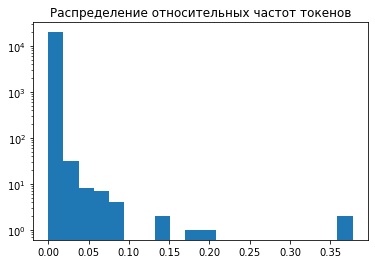

In [12]:
plt.hist(token2frequency, bins=20)
plt.title("Распределение относительных частот токенов")
plt.yscale("log")

plt.savefig(WORD_DISTRIBUTION_CHART, bbox_inches='tight')
plt.show()

# Text Length Analysis

In [13]:
text_lengths = list(map(len, unique_texts_tokenized))

print("Максимальная длина текста в токенах:", max(text_lengths))
print("Минимальна длина текста в токенах:", min(text_lengths))
print("Средняя длина текста в токенах:", sum(text_lengths) / len(text_lengths))

Максимальная длина текста в токенах: 164
Минимальна длина текста в токенах: 1
Средняя длина текста в токенах: 13.871706605851431


In [17]:
with open(FIT_TOKENIZER, "wb") as outfile:
    pickle.dump(TOKENIZER, outfile)